# Gaussian Process (GP) Regression using GPyTorch

Author: [Richard Cornelius Suwandi](https://richardcsuwandi.github.io)

In this tutorial, I'm going to demonstrate how to perform Gaussian Process (GP) regression using GPyTorch. 
[GPytorch](https://github.com/cornellius-gp/gpytorch) is a Gaussian process library implemented using PyTorch that is designed for creating scalable and flexible, and modular GP models. You can learn more about GPyTorch on their [official website](https://gpytorch.ai).

## Setup
Let's first import the necessary libraries for this tutorial. If you haven't installed `gpytorch`, you can install it either using pip or conda:

```bash
pip install gpytorch
conda install gpytorch -c gpytorch
```
You can also check the requirements and installation instructions on their website [here](https://gpytorch.ai/#install).

In [1]:
# Import the necessary libraries
import math
from matplotlib import pyplot as plt
import torch
import gpytorch

## Generating the data
Next, we need to generate a training data for our model. We will be modeling the following function:

\begin{align}
    y = \sin{(2 \pi x)} + \epsilon, \enspace \epsilon \sim \mathcal{N}(0, 0.04)
\end{align}
where $\epsilon$ is the Gaussian noise. We will evaluate the above function on 15 equally-spaced points from $[0,1]$:

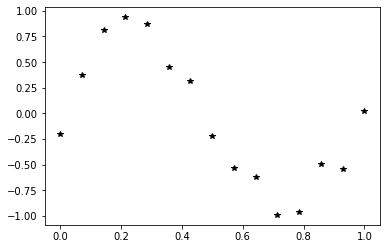

In [13]:
# The training data is 15 equally-spaced points from [0,1] 
x_train = torch.linspace(0, 1, 15)

# The true function is sin(2*pi*x) with Gaussian noise N(0, 0.04)
y_train = torch.sin(x_train * (2 * math.pi)) + torch.randn(x_train.size()) * math.sqrt(0.04)

# Plot training data as black stars
plt.plot(x_train.numpy(), y_train.numpy(), 'k*')

## Building the model
GPyTorch offers a flexible way for us to build GP models, by constructing the components of the model by ourselves. This is analogous to building neural networks in the standard PyTorch library. For most GP regression models, you will need to construct the following components:
1. **A GP Model**: For exact (i.e. non-variational) GP models we will use `gpytorch.models.ExactGP`
2. **A likelihood function**: The likelihood function for GP regression, we commonly use `gpytorch.likelihoods.GaussianLikelihood`.
3. **A mean function**: The prior mean of the GP. If you don't know which mean to use, `gpytorch.means.ConstantMean()` is usually a good place to start.
4. **A kernel function**: The prior covariance of the GP. We'll use the [Spectral Mixture (SM) kernel](https://arxiv.org/pdf/1302.4245.pdf) (`gpytorch.kernels.SpectralMixtureKernel()`) for this tutorial.
5. **A multivariate normal distribution**: An object to represent the multivariate normal distribution (`gpytorch.distributions.MultivariateNormal`)

Now, let's build our GP model by constructing its components:

In [6]:
# A GP model with constant mean function and spectral mixture (SM) kernel
class SpectralMixtureGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(SpectralMixtureGP, self).__init__(x_train, y_train, likelihood)
        self.mean = gpytorch.means.ConstantMean() # Construct the mean function
        self.cov = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4) # Construct the kernel function
        self.cov.initialize_from_data(x_train, y_train) # Initialize the hyperparameters from data
        
    def forward(self, x):
        # Evaluate the mean and kernel function at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        # Return the multivariate normal distribution using the evaluated mean and kernel function
        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x) 
        
# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGP(x_train, y_train, likelihood)

## Training the model
Now that we have built the model, we can train the model to find the optimal hyperparameters. Training a GP model in GPyTorch is also analogous to training a neural network in the standard PyTorch library. The training loop mainly consists of the following steps:
1. Setting all the parameter gradients to zero
2. Calling the model and computing the loss
3. Calling backward on the loss to fill in gradients
4. Taking a step on the optimizer

In [7]:
# Put the model into training mode
model.train()
likelihood.train()

# Use the Adam optimizer, with learning rate set to 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Use the negative marginal log-likelihood as the loss function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Set the number of training iterations
n_iter = 50

for i in range(n_iter):
    # Set the gradients from previous iteration to zero
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Compute loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.276
Iter 2/50 - Loss: 1.243
Iter 3/50 - Loss: 1.214
Iter 4/50 - Loss: 1.183
Iter 5/50 - Loss: 1.151
Iter 6/50 - Loss: 1.123
Iter 7/50 - Loss: 1.095
Iter 8/50 - Loss: 1.069
Iter 9/50 - Loss: 1.043
Iter 10/50 - Loss: 1.019
Iter 11/50 - Loss: 0.997
Iter 12/50 - Loss: 0.977
Iter 13/50 - Loss: 0.955
Iter 14/50 - Loss: 0.934
Iter 15/50 - Loss: 0.912
Iter 16/50 - Loss: 0.889
Iter 17/50 - Loss: 0.862
Iter 18/50 - Loss: 0.832
Iter 19/50 - Loss: 0.799
Iter 20/50 - Loss: 0.763
Iter 21/50 - Loss: 0.725
Iter 22/50 - Loss: 0.685
Iter 23/50 - Loss: 0.645
Iter 24/50 - Loss: 0.605
Iter 25/50 - Loss: 0.565
Iter 26/50 - Loss: 0.528
Iter 27/50 - Loss: 0.493
Iter 28/50 - Loss: 0.462
Iter 29/50 - Loss: 0.435
Iter 30/50 - Loss: 0.411
Iter 31/50 - Loss: 0.392
Iter 32/50 - Loss: 0.377
Iter 33/50 - Loss: 0.362
Iter 34/50 - Loss: 0.347
Iter 35/50 - Loss: 0.332
Iter 36/50 - Loss: 0.317
Iter 37/50 - Loss: 0.305
Iter 38/50 - Loss: 0.296
Iter 39/50 - Loss: 0.290
Iter 40/50 - Loss: 0.286
Iter 41/5

## Making predictions with the model
Next, we can make predicitions with the model by putting the model and likelihood in eval mode. We will evaluate the model using 50 equally-spaced points from $[0, 5]$ as our test data:

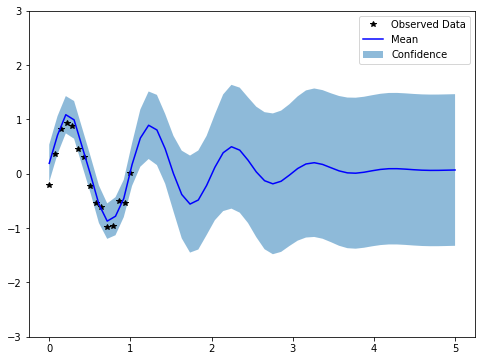

In [18]:
# The test data is 50 equally-spaced points from [0,5]
x_test = torch.linspace(0, 5, 50)

# Put the model into evaluation mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(x_test)
    f_mean = f_preds.mean
    f_cov = f_preds.covariance_matrix
    
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood(model(x_test))
    
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

The black stars in the above plot represent the training (observed) data, while the blue line and the shaded area represent the mean and the confidence bounds respectively. Notice how the uncertainty is reduced close to the observed points. If more data points were added, we would see the mean function adjust itself to pass through these points and the uncertainty would reduce close to the observations.